# Research links

ZFNet: https://medium.com/coinmonks/paper-review-of-zfnet-the-winner-of-ilsvlc-2013-image-classification-d1a5a0c45103



In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch, gc

c:\Users\Shlomi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [2]:
IMAGE_SIZE = [28, 28]
BOTTLENECK_DIM = 98  # Latent dim in autoencoder

TRAIN_BATCH_SIZE = 256
TRAIN_EPOCHS = 2

# Flush GPU memory, and garbadge collector

My GPU is always full, idk why but the jupyter kernel doesn't release the memory. So each run I flush the memory.

In [3]:
gc.collect()
torch.cuda.empty_cache()

# Load datasets

In [4]:
train_data_transformed = torchvision.datasets.MNIST(root="/MNIST", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(train_data_transformed, batch_size=TRAIN_BATCH_SIZE)
img, _ = next(iter(train_dataloader))

# Check GPU

In [5]:
if torch.cuda.is_available():
	device = torch.device('cuda:0')
	print("Using GPU")
else:
	device = torch.device('cpu')
	print("Using CPU")

Using GPU


ולגביי השאלה שלך איך לתת מוטיבציה. אז תשמור את הפלט מהשכבה החבויה של המקודד, ואת הפלט מהשכבה החבויה של המפרש,
תחשב את השגיאה ביניהם כמו שאתה מחשב את השגיאה של הקלט של המודל עם הפלט של המודל.
תסכום את שתי השגיאות, ואז תעשה backward. ככה המודל גם יתאמץ להגיע לשגיאה נמוכה בשכבות החבויות.

In [6]:
class Encoder(nn.Module):
	def __init__(self , image_size, latent_dim):
		super().__init__()
		# self.conv1   = nn.Conv2d(1, 32, 3,padding="same")
		# self.conv2   = nn.Conv2d(32, 32, 3,padding="same")
		# self.maxpool = nn.MaxPool2d(2) 
		# self.relu    = nn.ReLU()

		self.image_size = image_size
		self.linear1 = nn.Linear(self.image_size[0] * self.image_size[1], latent_dim)
		self.relu = nn.ReLU()

	def forward(self, image: torch.Tensor) -> torch.Tensor:
		# temp=self.relu(self.conv1(image))
		# temp=self.maxpool(temp)
		# temp=self.relu(self.conv2(temp))
		# feature_map=self.maxpool(temp)
		# return feature_map
		flat = image.flatten(start_dim=1)
		res = self.linear1(flat)
		res = self.relu(res)
		return res

class Decoder(nn.Module):
	def __init__(self, image_size, latent_dim):
		super().__init__()
		# self.conv1     = nn.ConvTranspose2d(32, 32, 7, stride=2)
		# self.conv2     = nn.ConvTranspose2d(32, 1, 10)
		# self.relu      = nn.ReLU()
		# self.sigmoid   = nn.Sigmoid()

		self.image_size = image_size
		self.linear1 = nn.Linear(latent_dim, image_size[0] * image_size[1])
		self.sigmoid = nn.Sigmoid()
	
	def forward(self, feature_map: torch.Tensor) -> torch.Tensor:
		# temp=self.relu(self.conv1(feature_map))
		# reconstructed_image=self.sigmoid(self.conv2(temp))
		# return reconstructed_image

		res = self.linear1(feature_map)
		res = self.sigmoid(res)
		res = res.reshape(-1, 1, self.image_size[0], self.image_size[1])
		return res

In [7]:
encoder = Encoder(IMAGE_SIZE, BOTTLENECK_DIM)
decoder = Decoder(IMAGE_SIZE, BOTTLENECK_DIM)

autoencoder = nn.Sequential(encoder,decoder).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters())
loss_func = nn.MSELoss()

In [8]:
def iterate_batch(imgs):
	imgs = imgs.to(device)
	optimizer.zero_grad()
	reconstructed=autoencoder(imgs)
	loss=loss_func(reconstructed,imgs)
	loss.backward()
	optimizer.step()
	return loss

In [9]:
batches=len(train_dataloader)

batch_loss=torch.empty(batches,device=device)
epoch_loss=torch.empty(TRAIN_EPOCHS,device=device)
for epoch_idx in tqdm(range(TRAIN_EPOCHS)):
	for batch_idx, (imgs, _) in enumerate(train_dataloader):
		batch_loss[batch_idx] = iterate_batch(imgs)
	with torch.no_grad():
		epoch_loss[epoch_idx]=batch_loss.mean()

100%|██████████| 2/2 [00:11<00:00,  5.89s/it]


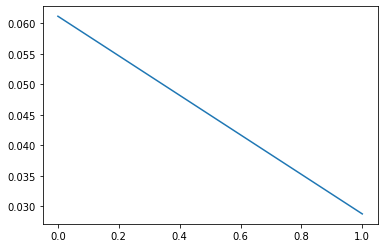

In [10]:
plt.plot(epoch_loss[:epoch_idx+1].cpu().detach());

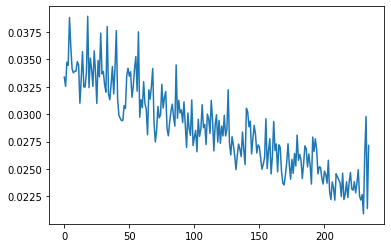

In [11]:
plt.plot(batch_loss.cpu().detach());

In [12]:
imgs, _ = next(iter(train_dataloader))

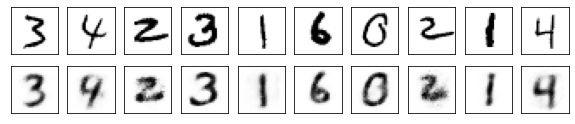

In [13]:
num_images=10
with torch.no_grad():
	reconstructed=autoencoder(imgs.to(device)).cpu()
	fig,axes = plt.subplots(2,num_images,sharey=True)
	fig.set_figheight(2)
	fig.set_figwidth(10)
	rand_idx=torch.randint(size=(num_images,),high=imgs.size(0))
	for idx in range(num_images):
		axes[0,idx].imshow(imgs[rand_idx[idx],...].reshape(28,28).detach(),cmap='Greys')
		axes[0,idx].axes.get_xaxis().set_visible(False)
		axes[0,idx].axes.get_yaxis().set_visible(False)

		axes[1,idx].imshow(reconstructed[[rand_idx[idx]],...].reshape(28,28).detach(),cmap='Greys')
		axes[1,idx].axes.get_xaxis().set_visible(False)
		axes[1,idx].axes.get_yaxis().set_visible(False)


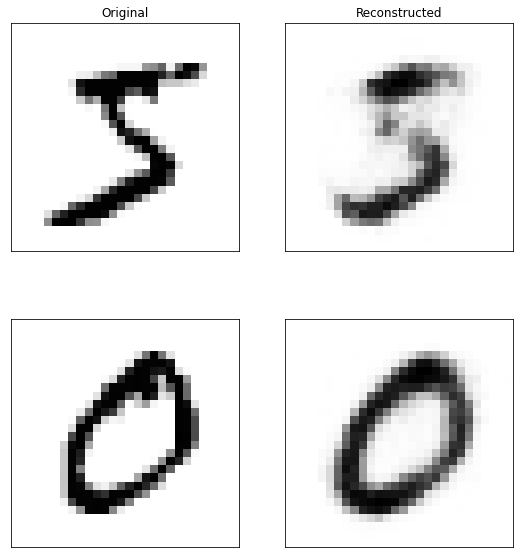

In [14]:
num_images=2
with torch.no_grad():
  reconstructed=autoencoder(imgs.to(device)).cpu()
  fig,axes = plt.subplots(num_images,2)
  fig.set_figheight(10)
  fig.set_figwidth(9)
  for idx in range(num_images):
    axes[idx,0].imshow(imgs[idx,...].reshape(28,28).detach(),cmap='Greys')
    axes[idx,0].axes.get_xaxis().set_visible(False)
    axes[idx,0].axes.get_yaxis().set_visible(False)
    

    axes[idx,1].imshow(reconstructed[idx,...].reshape(28,28).detach(),cmap='Greys')
    axes[idx,1].axes.get_xaxis().set_visible(False)
    axes[idx,1].axes.get_yaxis().set_visible(False)
axes[0,0].set_title("Original");
axes[0,1].set_title("Reconstructed");